<a href="https://colab.research.google.com/github/skosch/YinYangFit/blob/master/YinYangFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import os

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
elif False:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)

TF version: 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available
Found GPU at: /device:GPU:0


In [12]:
import itertools
import os

import numpy as np
pi = np.pi

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import tensorflow as tf
import tensorflow_probability as tfp
import random; random.seed()
import math
import pickle
import os
from tqdm import tqdm as tqdm
import sys
from functools import reduce
import random
from itertools import cycle, islice, product
import operator
from scipy.linalg import toeplitz

!pip install --quiet tensorfont
!pip install --quiet fonttools
!pip install --quiet --upgrade fontParts
!pip install booleanOperations
!pip install --quiet --upgrade ufo-extractor
!pip install --quiet --upgrade defcon
!pip install --quiet --upgrade ufo2ft
import fontParts
import extractor
import defcon
from ufo2ft import compileOTF

from tensorfont import Font

print("✓ Dependencies imported.")

✓ Dependencies imported.


In [4]:
#!wget -q -O OpenSans-Regular.ttf https://github.com/googlefonts/opensans/blob/master/ttfs/OpenSans-Regular.ttf?raw=true
#!wget -q -O Roboto.ttf https://github.com/google/fonts/blob/master/apache/roboto/Roboto-Regular.ttf?raw=true
#!wget -q -O Roboto.otf https://github.com/AllThingsSmitty/fonts/blob/master/Roboto/Roboto-Regular/Roboto-Regular.otf?raw=true
#!wget -q -O DroidSerif.ttf https://github.com/datactivist/sudweb/blob/master/fonts/droid-serif-v6-latin-regular.ttf?raw=true
!wget -q -O CrimsonItalic.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Italic.otf?raw=true
#!wget -q -O CrimsonBold.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Bold.otf?raw=true 
#!wget -q -O CrimsonRoman.otf https://github.com/alif-type/amiri/blob/master/Amiri-Regular.ttf?raw=true

!wget -q -O CrimsonRoman.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Roman.otf?raw=true
print("✓ Font file(s) downloaded.")

✓ Font file(s) downloaded.


In [5]:
glyph_char_list = "abcdefghijklmnopqrstuvwxyz"
#glyph_char_list = "abgjqrst"
#glyph_char_list = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#glyph_char_list = "OO"
#glyph_char_list = "abc"

# ==== Create Font ====
factor = 1.0 #1.539  # This scales the size of everything
filename = "CrimsonRoman.otf"
f = Font(filename, 34 * factor) # Roboto.ttf CrimsonRoman.otf # 34 for lowercase
box_height = int(f.full_height_px)
box_width = int(161 * factor) # 121
box_width += (box_width + 1) % 2
print("Box size:", box_height, "×", box_width)

batch_size = 2
sample_distance_deltas = [-2, 0, 2]
sample_distance_factors = [.3, 1., 4.4]
n_sample_distances = len(sample_distance_deltas)

n_v1_scales = 5
n_b_scales = 1
n_v1_orientations = 4
n_v4_scales = 1

Box size: 80 × 161


In [6]:
def get_sigmas(skip_scales=0):
    sigmas = []
    for s in range(n_v1_scales):
        min_sigma = 0.7
        max_sigma = box_width / 15
        sigmas.append((max_sigma - min_sigma) * (s + skip_scales)**2 / (n_v1_scales - 1)**2 + min_sigma)
        #sigmas.append((max_sigma - min_sigma) * s / n_v1_scales + min_sigma)
    return np.array(sigmas)

print("Spatial frequency scales:", get_sigmas())

def get_v1_filter_bank(skip_scales, display_filters=False):
    def rotated_mgrid(oi):
        """Generate a meshgrid and rotate it by RotRad radians."""
        rotation = np.array([[ np.cos(pi*oi/n_v1_orientations), np.sin(pi*oi/n_v1_orientations)],
                             [-np.sin(pi*oi/n_v1_orientations), np.cos(pi*oi/n_v1_orientations)]])
        hh = box_height # / 2
        bw = box_width # / 2
        y, x = np.mgrid[-hh:hh, -bw:bw].astype(np.float32)
        y += 0.5 # 0 if box_height % 2 == 0 else 0.5
        x += 0.5 # 0 if box_width % 2 == 0 else 0.5
        return np.einsum('ji, mni -> jmn', rotation, np.dstack([x, y]))

    def get_filter(s, theta):
        x, y = rotated_mgrid(theta)

        # To minimize ringing etc., we create the filter as is, then run it through the DFT.

        # First derivative (odd filter/up-down)
        d1_space = np.exp(-(x**2+y**2)/(2*s**2))*x/(2*pi*s**4)
        d1_relu_sum = np.sum(d1_space * (d1_space > 0))
        d1 = np.fft.fft2(np.fft.ifftshift(d1_space + 1j * np.zeros_like(d1_space)))

        # Second derivative (even filter/mexican hat):
        s2 = s * .85 # To make them about the same width
        d2_space = np.exp(-(x**2+y**2)/(2*s2**2))/(2*pi*s2**4) - np.exp(-(x**2+y**2)/(2*s2**2))*x**2/(2*pi*s2**6)
        d2_relu_sum = np.sum(d2_space * (d2_space > 0))
        d2 = (d1_relu_sum / d2_relu_sum) * np.fft.fft2(np.fft.ifftshift(d2_space + 1j * np.zeros_like(d2_space)))

        return (d1 + 1j*d2) / (5 * np.max(tf.abs(d1+1j*d2))) # Max output should be about 0.2, which leaves lots of flexibility for the HRA later

    filter_bank = np.zeros((n_v1_scales, n_v1_orientations, 2*box_height, 2*box_width)).astype(np.complex64)

    if display_filters:
        sizediv = 20
        fig, ax = plt.subplots(nrows=n_v1_scales*2, ncols=n_v1_orientations, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * n_v1_orientations / sizediv, box_height * n_v1_scales * 2 / sizediv))

    sigmas = get_sigmas()
    for s in range(n_v1_scales):
        sigma = sigmas[s]
        for o in range(n_v1_orientations):
            f = get_filter(sigma, o)
            if display_filters:
                mx = np.max(np.abs(np.imag(np.fft.ifft2(f))))
                ax[s*2, o].imshow(np.real(np.fft.fftshift(np.fft.ifft2(f))), cmap="RdBu", vmin=-mx, vmax=mx)
                ax[s*2, o].set_aspect("auto")
                ax[s*2, o].set_yticklabels([])
                ax[s*2+1, o].imshow(np.imag(np.fft.fftshift(np.fft.ifft2(f))), cmap="RdBu", vmin=-mx, vmax=mx)
                ax[s*2+1, o].set_aspect("auto")
                ax[s*2+1, o].set_yticklabels([])
            filter_bank[s, o, :, :] = f

    if display_filters:
        plt.show()

    return filter_bank.astype(np.complex64)

filter_bank = get_v1_filter_bank(0, display_filters=False)


def apply_filter_bank(input_image, filter_bank):
    """
    Input image should have dimensions <h, w> or <s, o, h, w> or <b, s, o, h, w, d>.
    Filter bank should have dimensions <s, o, h, w>
    """
    bdsohw_input_image = input_image[None, None, None, None, :, :]

    # pad image to filter size, which is 2*box_height, 2*box_width (to prevent too much wrapping)
    padded_input = tf.pad(bdsohw_input_image, [[0, 0], [0, 0], [0, 0], [0, 0],
                            [int(np.ceil(box_height / 2)), int(box_height / 2)],
                            [int(np.ceil(box_width / 2)), int(box_width / 2)]], mode='CONSTANT')

    input_in_freqdomain = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(padded_input, tf.zeros_like(padded_input))))

    padded_result = tf.signal.ifft2d(input_in_freqdomain * filter_bank[None, None, :, :, :, :])

    presult = tf.signal.fftshift(padded_result[0, 0, :, :, :, :], [2, 3])

    return presult[:, :, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))]

Spatial frequency scales: [ 0.7         1.32708333  3.20833333  6.34375    10.73333333]


100%|██████████| 26/26 [00:00<00:00, 1054.18it/s]

  ✓ 26 glyphs rendered.



100%|██████████| 26/26 [00:00<00:00, 60956.91it/s]

  ✓ 26 glyphs measured.



100%|██████████| 26/26 [00:02<00:00, 10.89it/s]

  ✓ 26 glyphs filtered.


Scale: 0


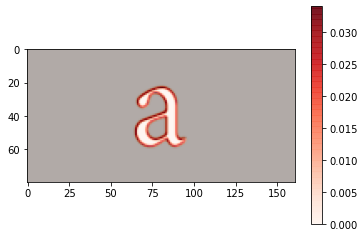

Scale: 1


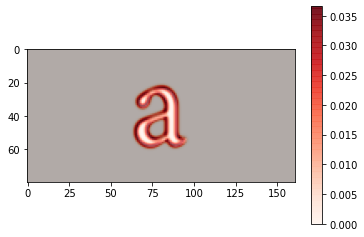

Scale: 2


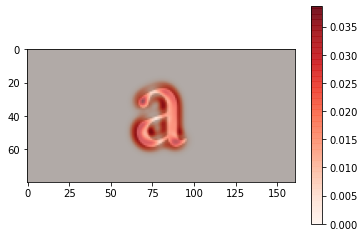

Scale: 3


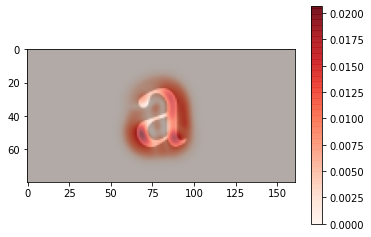

Scale: 4


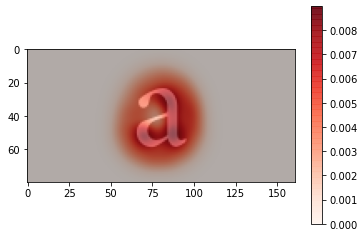

100%|██████████| 26/26 [00:00<00:00, 106.73it/s]

  ✓ 676 pairs assembled.

  ✓ Dataset ready.


In [7]:
# 1. Render glyphs

def get_glyph_image(glyph_char):
    """Returns a np.array of shape [box_height, box_width] containing the glyph at the center."""
    return f.glyph(glyph_char).as_matrix(normalize=True).with_padding_to_constant_box_width(box_width).astype(np.float32)

def get_glyph_ink_width(glyph_char):
    """Returns the width of the rendered glyph in pixels."""
    return f.glyph(glyph_char).ink_width

def get_v1_response(glyph_image):
    """Returns a np.array of shape [n_v1_scales, n_v1_orientations, box_height, box_width] and type complex64,
    containing the local responses to the V1 filter bank (after inverse Fourier transform, i.e. in the spatial domain)."""
    with tf.device("/gpu:0"):
        filtered = apply_filter_bank(glyph_image, filter_bank)
    return filtered

glyph_images = {c: get_glyph_image(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs rendered.", flush=True)
glyph_ink_widths = {c: get_glyph_ink_width(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs measured.", flush=True)
glyph_v1_responses = {c: get_v1_response(glyph_images[c]) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs filtered.", flush=True)

# 1a. Show an example of filtered glyphs
for si in range(n_v1_scales):
    print("Scale:", si)
    plt.imshow(glyph_images["a"], cmap="gray")
    plt.imshow(np.sum(np.abs(glyph_v1_responses["a"][si, :, :, :]), (0))**2, cmap="Reds", alpha=0.7)
    plt.colorbar()
    plt.show()

# 2. Assemble pairs

def get_pair_translations(char1, char2, distance_deltas, distance_factors=None):
    """Returns two 1D arrays of distances (in pixels) by which the left and right glyph need to be translated (i.e. shifted horizontally)
    in order to place the two glyphs at the desired distances.
    
    Example: distance_deltas = [-2, 0, 2] or distance_factors=[0.7, 1.0, 1.5]
    """

    optimal_distance = int(f.pair_distance(char1, char2) + f.minimum_ink_distance(char1, char2))

    if distance_factors is None:
        if distance_deltas is None:
            raise ValueError("Must provide either distance_deltas or distance_factors")
        
        sample_distances = optimal_distance + np.array(distance_deltas)
    else:
        if distance_deltas is not None:
            raise ValueError("Must provide either distance_deltas or distance_factors, not both")

        sample_distances = optimal_distance * np.array(distance_factors)

    total_width_at_minimum_ink_distance = glyph_ink_widths[char1] + glyph_ink_widths[char2] - f.minimum_ink_distance(char1, char2)
    total_ink_width = glyph_ink_widths[char1] + glyph_ink_widths[char2]
    ink_width_left = np.floor(total_ink_width / 4)
    ink_width_right = np.ceil(total_ink_width / 4)
    sample_distances_left = np.ceil(sample_distances / 2)
    sample_distances_right = np.floor(sample_distances / 2)

    left_translations = (-(np.ceil(total_width_at_minimum_ink_distance/2) + sample_distances_left) - (-ink_width_left)).astype(np.int32)
    right_translations = ((np.floor(total_width_at_minimum_ink_distance/2) + sample_distances_right) - ink_width_right).astype(np.int32)
    
    return (left_translations, right_translations)
    
left_images = []
right_images = []
left_v1_responses = []
right_v1_responses = []
left_translations = []
right_translations = []

for c1 in tqdm(glyph_char_list):
    for c2 in reversed(glyph_char_list):
        left_images.append(glyph_images[c1])
        right_images.append(glyph_images[c2])
        left_v1_responses.append(glyph_v1_responses[c1])
        right_v1_responses.append(glyph_v1_responses[c2])

        lt, rt = get_pair_translations(c1, c2, sample_distance_deltas) #, sample_distance_factors)
        left_translations.append(lt)
        right_translations.append(rt)

print("  ✓", len(glyph_char_list)**2, "pairs assembled.")

# 3. Set up generator to yield pairs, and wrap generator in a tf.Dataset

def return_pair():
    i = 0
    while i < len(left_images):
        yield {
            "left_image": left_images[i],
            "right_image": right_images[i],
            "left_v1_response": left_v1_responses[i],
            "right_v1_response": right_v1_responses[i],
            "left_translations": left_translations[i],
            "right_translations": right_translations[i],
        }
        i = (i + 1) % len(left_images)

dataset = tf.data.Dataset.from_generator(
     return_pair,
     {
      "left_image": tf.float32,
      "right_image": tf.float32,
      "left_v1_response": tf.complex64,
      "right_v1_response": tf.complex64,#
      "left_translations": tf.int32,
      "right_translations": tf.int32,
     },
     {
      "left_image": tf.TensorShape([box_height, box_width]),
      "right_image": tf.TensorShape([box_height, box_width]),
      "left_v1_response": tf.TensorShape([n_v1_scales, n_v1_orientations, box_height, box_width]),
      "right_v1_response": tf.TensorShape([n_v1_scales, n_v1_orientations, box_height, box_width]),
      "left_translations": tf.TensorShape([n_sample_distances,]),
      "right_translations": tf.TensorShape([n_sample_distances,])
     },
)

print("\n  ✓ Dataset ready.")

In [8]:
# 4. Apply horizontal translations in the dataset

def translate_4d_image(input_image, translations):
    """Shifts images to left/right and back-fills with zeros.
    @param image: <sizes, orientations, height, width>
    @param translations: <len(translations)>
    @output        <len(translations), sizes, orientations, height, width>
    """

    images = tf.tile(input_image[:, :, :, :, None], [1, 1, 1, 1, translations.shape[0]]) # create len(shifts) channel copies
    fill_constant = 0
    left = tf.maximum(0, tf.reduce_max(translations)) # positive numbers are shifts to the right, for which we need to add zeros on the left
    right = -tf.minimum(0, tf.reduce_min(translations)) # negative numbers are shifts to the left, for which we need to add zeros on the right
    left_mask = tf.ones(shape=(tf.shape(images)[0], tf.shape(images)[1], tf.shape(images)[2], left, tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    right_mask = tf.ones(shape=(tf.shape(images)[0], tf.shape(images)[1], tf.shape(images)[2], right, tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    padded_images = tf.concat([left_mask, images, right_mask], axis=3) # pad on axis 3 (i.e. width-wise)

    # Now that the images are all padded, we need to crop them to implement the shifts.
    def crop_image_widthwise(image_and_shift):
        image = image_and_shift[0] # sohw
        shift = image_and_shift[1] # 
        return image[:, :, :, left-shift:left-shift+input_image.shape[3]] # positive shift: left-shift

    result = tf.map_fn(
        crop_image_widthwise,
        (tf.einsum("sohwd->dsohw", padded_images), translations),
        dtype=images.dtype)

    # Manually ensure that the width-dimension hasn't changed
    s = list(result.shape)
    s[-1] = box_width
    result.set_shape(s)

    return result

def apply_translations(d):
    d["left_image"] = translate_4d_image(d["left_image"][None, None, :, :], d["left_translations"])[:, 0, 0, :, :]
    d["right_image"] = translate_4d_image(d["right_image"][None, None, :, :], d["right_translations"])[:, 0, 0, :, :]
    d["left_v1_response"] = translate_4d_image(d["left_v1_response"], d["left_translations"])
    d["right_v1_response"] = translate_4d_image(d["right_v1_response"], d["right_translations"])
    del d["left_translations"]
    del d["right_translations"]
    return (d, 0.)  # The zero here doesn't do anything and is just to make Keras happy, because model.fit expects a dataset of 2-tuples where the second entry is the target value.

translated_dataset = dataset.map(apply_translations)

print("dataset shapes:", translated_dataset.element_spec)

dataset shapes: ({'left_image': TensorSpec(shape=(3, 80, 161), dtype=tf.float32, name=None), 'right_image': TensorSpec(shape=(3, 80, 161), dtype=tf.float32, name=None), 'left_v1_response': TensorSpec(shape=(3, 5, 4, 80, 161), dtype=tf.complex64, name=None), 'right_v1_response': TensorSpec(shape=(3, 5, 4, 80, 161), dtype=tf.complex64, name=None)}, TensorSpec(shape=(), dtype=tf.float32, name=None))


In [22]:
print(tfp.distributions.LogNormal(-2,.5).prob([eps]))

tf.Tensor([0.], shape=(1,), dtype=float32)


In [36]:
# 5. Utility functions
eps = np.finfo(np.float32).tiny

def invspa(t):
    return np.log(np.exp(t) - 1).astype(np.float32)

def invsp(t):
    if t == 0:
        return -1e10
    else:
        return np.log(np.exp(t) - 1).astype(np.float32)

def sp(t):
    return tf.nn.softplus(t)

# 6. Generating G-cell fragments

u, v = np.mgrid[-box_height:box_height,-box_width:box_width].astype(np.float32)
u = u / (box_width)
v = v / (box_width)
r = np.sqrt(u**2 + v**2)[None, None, :, :]
angle = np.arctan2(u, v)[None, None, :, :] # <b, d, s, o, c, h, w>
angles = np.arange(n_v1_orientations)[:, None, None, None].astype(np.float32)/n_v1_orientations
angle_mask_widths = 4. * np.ones((n_v1_orientations, n_v4_scales)).astype(np.float32)

def make_v4_filters(k, spa, sn, hp, hn, cp, cn): # Returns masks of shape <o, c, h, w>
    p_mask_1 = tf.exp(-(r-sp(cp[None,:,None, None]))**2 / sp(spa[None, :, None, None])) * sp(hp[None, :, None, None])
    #p_mask_2 = tf.exp(-(-r-sp(cp[None, :, None, None]))**2 / sp(spa[None, :, None, None])) * sp(hp[None, :, None, None])
    p_logmask = tfp.distributions.LogNormal(tf.reduce_mean(cp), tf.reduce_mean(spa), validate_args=True, allow_nan_stats=False).prob(r+eps)
    n_mask_1 = tf.exp(-(r-sp(cn[None, :, None, None]))**2 / sp(sn[None, :, None, None])) * sp(hn[None, :, None, None])
    #n_mask_2 = tf.exp(-(-r-sp(cn[None, :, None, None]))**2 / sp(sn[None, :, None, None])) * sp(hn[None, :, None, None])
    radial_mask = p_logmask #p_mask_1 #- n_mask_1

    #flat_indices = tf.reshape((r * box_width).astype(np.int), [4 * box_height * box_width])
    #radial_mask = tf.reshape(tf.gather(sp(k), flat_indices), [1, 1, 2 * box_height, 2*box_width])

    # Uses von-Mises distribution (via Bessel function)
    bp_angle_masks = tf.exp(-angle_mask_widths[:, :, None, None] * tf.cos(angle - pi - pi * angles)) / (2*pi*tf.math.bessel_i0(angle_mask_widths[:, :, None, None]))
    bn_angle_masks = tf.exp(-angle_mask_widths[:, :, None, None] * tf.cos(angle - pi * angles)) / (2*pi*tf.math.bessel_i0(angle_mask_widths[:, :, None, None]))

    bp_masks = radial_mask * bp_angle_masks
    bn_masks = radial_mask * bn_angle_masks

    # Each bp/bn_mask fragment (the positive part) should add up to exactly one.
    bp_masks_normed = 4*bp_masks / (eps + tf.reduce_sum((bp_masks)**2, [0, 2, 3], keepdims=True))
    bn_masks_normed = 4*bn_masks / (eps + tf.reduce_sum((bn_masks)**2, [0, 2, 3], keepdims=True))

    return tf.concat([bp_masks_normed, bn_masks_normed], axis=0)


# 7. V4 layer
class V4Layer(tf.keras.layers.Layer):
    def __init__(self, skip_v4_convolution=False, **kwargs):
        super(V4Layer, self).__init__(**kwargs)

        self.skip_v4_convolution = skip_v4_convolution

        self.csf = self.add_weight(shape=((n_v1_scales, n_v1_orientations)),
                                 initializer=tf.keras.initializers.Constant(np.tile(np.array([20, 10, 3, 0.5, 0.1])[:, None], [1, n_v1_orientations]).astype(np.float32)),
                                 name="csf",
                                 trainable=True)

        self.v1_hra_k = self.add_weight(shape=((n_v1_scales, n_v1_orientations)),
                                 initializer=tf.keras.initializers.Constant(np.tile(invsp([2.4,2.4,2.4,2.4,2.4])[:, None], [1, n_v1_orientations])), # 1 to .02
                                 name="v1_hra_k",
                                 trainable=True)
        self.v1_hra_b = self.add_weight(shape=((n_v1_scales, n_v1_orientations)),
                                 initializer=tf.keras.initializers.Constant(np.tile(invsp([.06,.06,.06,.06,.06])[:, None], [1, n_v1_orientations])), # 1 to .02
                                 name="v1_hra_b",
                                 trainable=True)

        #self.v4_scales_exponent = self.add_weight(shape=(), initializer=tf.keras.initializers.Constant(1.5), name="v4_scales_exponent", trainable=False)
        #self.v4_scales_min = self.add_weight(shape=(), initializer=tf.keras.initializers.Constant(.54), name="v4_scales_min", trainable=False)
        #self.v4_scales_factor = self.add_weight(shape=(), initializer=tf.keras.initializers.Constant(0.75), name="v4_scales_factor", trainable=False)
#
        #self.v4_widths_exponent = self.add_weight(shape=(), initializer=tf.keras.initializers.Constant(1.5), name="v4_widths_exponent", trainable=False)
        #self.v4_widths_min = self.add_weight(shape=(), initializer=tf.keras.initializers.Constant(.6), name="v4_widths_min", trainable=False)
        #self.v4_widths_factor = self.add_weight(shape=(), initializer=tf.keras.initializers.Constant(0.2), name="v4_widths_factor", trainable=False)
#
        #self.v4_depression_scale_fraction = self.add_weight(shape=(n_v4_scales), initializer=tf.keras.initializers.Constant(np.array([0.3, .3, .3, .3, .3]).astype(np.float32)), name="v4_depression_scale_fraction", trainable=True)
        #self.v4_inner_negative_depth = self.add_weight(shape=(n_v4_scales), initializer=tf.keras.initializers.Constant(np.array([1.,1.,1.,1.,1.]).astype(np.float32)), name="v4_inner_negative_depth", trainable=True)

        # How far away from the center we are
        #self.v4_cp = self.add_weight(shape=(n_v4_scales), initializer=tf.keras.initializers.Constant(invspa(np.array([0.0125, 0.016, 0.021, 0.03, 0.056, 0.08, .12, .2]).astype(np.float32))), name="v4_cp", trainable=True)
        #self.v4_cn = self.add_weight(shape=(n_v4_scales), initializer=tf.keras.initializers.Constant(invspa(np.array([0.0125, 0.016, 0.021, 0.03, 0.056, 0.08, .12, .2]).astype(np.float32) * 0.16)), name="v4_cn", trainable=True)
        ## How wide the rims are
        #self.v4_sp = self.add_weight(shape=(n_v4_scales), initializer=tf.keras.initializers.Constant(invspa(np.array([0.00015, 0.00026, 0.00057, 0.00109, .00216, .0036, .0060, .0097]).astype(np.float32))), name="v4_sp", trainable=True)
        #self.v4_sn = self.add_weight(shape=(n_v4_scales), initializer=tf.keras.initializers.Constant(invspa(np.array([0.00015, 0.00026, 0.00057, 0.00109, .00216, .0036, .0060, .0097]).astype(np.float32) * .25)), name="v4_sn", trainable=True)
        ## How deep the rims are
        #self.v4_hp = self.add_weight(shape=(n_v4_scales), initializer=tf.keras.initializers.Constant(invspa(np.array([.8, .8, .8, .8, .8, .8, .8, .8]).astype(np.float32))), name="v4_hp", trainable=True)
        #self.v4_hn = self.add_weight(shape=(n_v4_scales), initializer=tf.keras.initializers.Constant(invspa(np.array([.4, .4, .4, .4, .4, .4, .4, .4]).astype(np.float32)*4.)), name="v4_hn", trainable=True)

        #self.v4_cp = self.add_weight(shape=(n_v4_scales), initializer=tf.keras.initializers.Constant(invspa(np.array([0.03]).astype(np.float32))), name="v4_cp", trainable=True)
        self.v4_cp = self.add_weight(shape=(n_v4_scales), initializer=tf.keras.initializers.Constant(np.array([-3]).astype(np.float32)), name="v4_cp", trainable=True)
        self.v4_cn = self.add_weight(shape=(n_v4_scales), initializer=tf.keras.initializers.Constant(invspa(np.array([0.03]).astype(np.float32))), name="v4_cn", trainable=True)
        # How wide the rims are
        #self.v4_sp = self.add_weight(shape=(n_v4_scales), initializer=tf.keras.initializers.Constant(invspa(np.array([0.00109]).astype(np.float32))), name="v4_sp", trainable=True)
        self.v4_sp = self.add_weight(shape=(n_v4_scales), initializer=tf.keras.initializers.Constant(np.array([.2]).astype(np.float32)), name="v4_sp", trainable=True)
        self.v4_sn = self.add_weight(shape=(n_v4_scales), initializer=tf.keras.initializers.Constant(invspa(np.array([0.00109]).astype(np.float32))), name="v4_sn", trainable=True)
        # How deep the rims are
        self.v4_hp = self.add_weight(shape=(n_v4_scales), initializer=tf.keras.initializers.Constant(invspa(np.array([.8]).astype(np.float32))), name="v4_hp", trainable=True)
        self.v4_hn = self.add_weight(shape=(n_v4_scales), initializer=tf.keras.initializers.Constant(invspa(np.array([.4]).astype(np.float32)*4.)), name="v4_hn", trainable=True)

        self.kk = self.add_weight(shape=(box_width * 2), initializer=tf.keras.initializers.Constant(invspa(np.array([.4]).astype(np.float32)*4.)), name="v4_kk", trainable=True)

        #self.v4_scales = self.add_weight(shape=(n_v4_scales),
        #                              initializer=tf.keras.initializers.Constant(np.array([.4,1.1,2.1,4.0,7.5]).astype(np.float32)/box_width),
        #                              #initializer=tf.keras.initializers.Constant(np.array([1.4,1.6,1.75,1.83,1.9]).astype(np.float32)),
        #                              name="v4_scales", trainable=False)
        #self.v4_widths = self.add_weight(shape=(n_v4_scales),
        #                                    initializer=tf.keras.initializers.Constant(np.array([.5,0.7,1.,1.7,3.8]).astype(np.float32)/box_width),
        #                                    #initializer=tf.keras.initializers.Constant(np.array([1.4,1.25,1.15,1.03,.98]).astype(np.float32)),
        #                                    name="v4_widths", trainable=False)
        self.v4_angle_mask_widths = self.add_weight(shape=(n_v1_orientations, n_v4_scales),
                                                 initializer=tf.keras.initializers.Constant(4.),
                                                 name="v4_angle_mask_widths", trainable=False)
        self.v4_filter_strengths = self.add_weight(shape=(n_v1_orientations, n_v4_scales),
                                               initializer=tf.keras.initializers.Constant(1.),
                                               name="v4_filter_strengths", trainable=False)

        self.v4_hra_k = self.add_weight(shape=(2*n_v1_orientations, n_v4_scales),
                                 #initializer=tf.keras.initializers.Constant(np.tile(invsp([1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4])[None, :], [2*n_v1_orientations, 1])),
                                 initializer=tf.keras.initializers.Constant(np.tile(invsp([1.4])[None, :], [2*n_v1_orientations, 1])),
                                 name="v4_hra_k",
                                 trainable=True)
        self.v4_hra_b = self.add_weight(shape=(2*n_v1_orientations, n_v4_scales),
                                 #initializer=tf.keras.initializers.Constant(np.tile(invsp([1.5,3,2,1,1, 1,1,1])[None, :], [2*n_v1_orientations, 1])),
                                 initializer=tf.keras.initializers.Constant(np.tile(invsp([1])[None, :], [2*n_v1_orientations, 1])),
                                 name="v4_hra_b",
                                 trainable=True)


        # Each ring should only be able to draw from 
        self.v1_v4_scale_weights = self.add_weight(shape=(1, n_v4_scales),
                                 #initializer=tf.keras.initializers.Constant((eps + np.triu(np.ones((n_v1_scales, n_v4_scales))).astype(np.float32) * .5**toeplitz(np.zeros(n_v1_scales), np.arange(n_v4_scales)))),
                                 #initializer=tf.keras.initializers.Constant(np.array([1, 1, 1, 1, 1, 1, 1, 1])[None, :].astype(np.float32)),
                                 initializer=tf.keras.initializers.Constant(np.array([1])[None, :].astype(np.float32)),
                                 name="v1_v4_scale_weights",
                                 trainable=True)
        self.v1_v4_orientation_weights = self.add_weight(shape=(2*n_v1_orientations, n_v4_scales),
                                 initializer=tf.keras.initializers.Constant(1.),
                                 name="v1_v4_orientation_weights",
                                 trainable=True)

        self.v4_b_scale_weights = self.add_weight(shape=(1, n_v4_scales),
                                 #initializer=tf.keras.initializers.Constant((eps + np.triu(np.ones((n_v1_scales, n_v4_scales))).astype(np.float32) * .5**toeplitz(np.zeros(n_v1_scales), np.arange(n_v4_scales)))),
                                 initializer=tf.keras.initializers.Constant(1.),
                                 name="v4_b_scale_weights",
                                 trainable=True)
        self.v4_b_orientation_weights = self.add_weight(shape=(2*n_v1_orientations, n_v4_scales),
                                 initializer=tf.keras.initializers.Constant(1.),
                                 name="v4_b_orientation_weights",
                                 trainable=True)

        self.g_hra_k = self.add_weight(shape=(n_v4_scales),
                                 #initializer=tf.keras.initializers.Constant(invsp([4.4, 5.4, 4.4, 2.4, 2.4, 2, 2, 1.5])),
                                 initializer=tf.keras.initializers.Constant(invsp([2.5])),
                                 name="g_hra_k",
                                 trainable=True)
        self.g_hra_b = self.add_weight(shape=(n_v4_scales),
                                 #initializer=tf.keras.initializers.Constant(invsp([0.05, 0.08, 0.15, 0.4, 0.9, 1.3, 2.1, 4.2]).astype(np.float32)),
                                 initializer=tf.keras.initializers.Constant(invsp([.4]).astype(np.float32)),
                                 name="g_hra_b",
                                 trainable=True)

        self.feedback_modulation_strength = self.add_weight(shape=(1, 2*n_v1_orientations, 1, 1),
                                 initializer=tf.keras.initializers.Constant(invsp(1.)),
                                 name="feedback_modulation_strength",
                                 trainable=True)

        self.b_dn_b = self.add_weight(shape=(1, 2*n_v1_orientations),
                                 initializer=tf.keras.initializers.Constant(invsp(0.25)),
                                 name="b_dn_b",
                                 trainable=True)
        self.b_dn_k = self.add_weight(shape=(1, 2*n_v1_orientations),
                                 initializer=tf.keras.initializers.Constant(invsp(2.2)),
                                 name="b_dn_k",
                                 trainable=True)
        self.b_dn_k_pool = self.add_weight(shape=(1, 2*n_v1_orientations),
                                 initializer=tf.keras.initializers.Constant(invsp(3.9)),
                                 name="b_dn_k_pool",
                                 trainable=True)

        # We would want the normalization pool to mostly include, for each size/orientation, the opposite orientation.
        # We would also want to include smaller sizes. But perhaps that's not so important?

        basic_dn_matrix = np.zeros((1, 2*n_v1_orientations, 1, 2*n_v1_orientations)).astype(np.float32)

        # The first ones are the ones that count towards the second
        for s1 in range(1):
            for o1 in range(2*n_v1_orientations):
                for s2 in range(1):
                    for o2 in range(2*n_v1_orientations):
                        s_distance = np.exp(-(s1 - s2)**2)
                        basic_dn_matrix[s1, o1, s2, o2] = s_distance

        self.b_dn_weights = self.add_weight(shape=((1, 2*n_v1_orientations, 1, 2*n_v1_orientations)),
                                 initializer=tf.keras.initializers.Constant(invspa(basic_dn_matrix.astype(np.float32))),
                                 name="b_dn_weights",
                                 trainable=True)

        self.g_dn_b = self.add_weight(shape=(n_v4_scales),
                                 initializer=tf.keras.initializers.Constant(invsp(1.5)),
                                 name="g_dn_b",
                                 trainable=True)
        self.g_dn_k = self.add_weight(shape=(n_v4_scales),
                                 initializer=tf.keras.initializers.Constant(invsp(2.2)),
                                 name="g_dn_k",
                                 trainable=True)
        self.g_dn_k_pool = self.add_weight(shape=(n_v4_scales),
                                 initializer=tf.keras.initializers.Constant(invsp(1.5)),
                                 name="g_dn_k_pool",
                                 trainable=True)

        # We would want the normalization pool to mostly include, for each size/orientation, the opposite orientation.
        # We would also want to include smaller sizes. But perhaps that's not so important?

        basic_g_dn_matrix = np.zeros((n_v4_scales, n_v4_scales)).astype(np.float32)

        # The first ones are the ones that count towards the second
        for s1 in range(n_v4_scales):
            for s2 in range(n_v4_scales): # the smaller ones should always suppress the bigger ones
                s_distance = 1. if s1 <= s2 else 0.0001
                basic_g_dn_matrix[s1, s2] = s_distance

        self.g_dn_weights = self.add_weight(shape=((n_v4_scales, n_v4_scales)),
                                 initializer=tf.keras.initializers.Constant(invspa(basic_g_dn_matrix.astype(np.float32))),
                                 name="g_dn_weights",
                                 trainable=True)



    def get_v4_scales(self):
        return (tf.nn.relu(eps + tf.range(0, n_v4_scales * self.v4_scales_factor, self.v4_scales_factor) + self.v4_scales_min) ** tf.nn.relu(eps + self.v4_scales_exponent)) / box_width

    def get_v4_widths(self):
        return (tf.nn.relu(eps + tf.range(0, n_v4_scales * self.v4_widths_factor, self.v4_widths_factor) + self.v4_widths_min) ** tf.nn.relu(eps + self.v4_widths_exponent)) / box_width

    def print_weights(self):
        print("CSF")
        plt.imshow(self.csf.numpy())
        plt.colorbar()
        plt.show()
        print("HRA parameters:")
        print("---------")
        print("V1 (scales/orientations) exponents [k] and half-points [b]")
        plt.imshow(sp(self.v1_hra_k))
        plt.colorbar()
        plt.show()
        plt.imshow(sp(self.v1_hra_b))
        plt.colorbar()
        plt.show()

        print("G (scales/orientations) exponents [k] and half-points [b]")
        print(sp(self.g_hra_k))
        print(sp(self.g_hra_b))
        plt.plot(sp(self.g_hra_k))
        plt.show()
        plt.plot(sp(self.g_hra_b))
        plt.show()

        print("M")
        #v4_filters = (make_v4_filters(self.get_v4_scales(), self.get_v4_widths(), self.v4_angle_mask_widths, self.v4_depression_scale_fraction, self.v4_inner_negative_depth))[None, None, None, ...]
        v4_filters = make_v4_filters(self.kk, self.v4_sp, self.v4_sn, self.v4_hp, self.v4_hn, self.v4_cp, self.v4_cn)[None, None, None, ...]
        print(self.v4_sp.numpy(), self.v4_hp.numpy(), self.v4_cp.numpy())
        for i in range(n_v4_scales):
            plt.imshow(tf.reduce_sum(v4_filters[0, 0, 0, :, i, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                            int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], [0]))
            plt.colorbar()
            plt.show()

        #print("SCALES, WIDTHS, STRENGHTS", self.get_v4_scales().numpy(), "ORIGINALSTRENGHTS", self.v4_scales.numpy(), "\n WIDTHS", self.get_v4_widths().numpy(), "ORIGINALWIDTHS", self.v4_widths.numpy(), "\n", self.v4_filter_strengths.numpy())

        print("Forward linking matrix:")
        print("Scale weights:")
        plt.imshow(self.v1_v4_scale_weights[:, :])
        plt.colorbar()
        plt.show()
        print("Orientation weights:")
        plt.imshow(self.v1_v4_orientation_weights[: ,:])
        plt.colorbar()
        plt.show()

        print("BDN exponents: upper k:", sp(self.b_dn_k).numpy(), "pool k:", sp(self.b_dn_k_pool).numpy())
        print("BDN exponents, b:", sp(self.b_dn_b).numpy())
        print("BDN Weights (size 2):")
        plt.imshow(sp(self.b_dn_weights)[0, :, 0, :])
        plt.colorbar()
        plt.show()

        print("GDN exponents: upper k:", sp(self.g_dn_k).numpy(), "pool k:", sp(self.g_dn_k_pool).numpy())
        print("GDN exponents, b:", sp(self.g_dn_b).numpy())
        print("GDN Weights (size 2):")
        plt.imshow(sp(self.g_dn_weights)[:, :])
        plt.colorbar()
        plt.show()

    def hra_v1(self, i):
        k = sp(self.v1_hra_k[None, None, :, :, None, None])
        b = sp(self.v1_hra_b[None, None, :, :, None, None])
        return ((i + eps) ** k) / (eps + b**k + (i + eps) ** k)
        # We need to ensure that whatever comes out of v1 is scaled.
        # The point of V1 scaling is that complex cells respond nonlinearly in real life; such that
        # e.g. stems are active in the center, and not as much on the outside.
        # But we need to ensure that total energy is kept the same, and simply redistributed.
        # Question is whether there is a way to normalize this.

    def hra_v4(self, i):
        return i
        k = sp(self.v4_hra_k[None, None, :, :, None, None])
        b = sp(self.v4_hra_b[None, None, :, :, None, None])
        return ((i + eps) ** k) # / (eps + b**k + (i + eps) ** k)

    def hra_g(self, i):
        k = sp(self.g_hra_k[None, None, :, None, None])
        b = sp(self.g_hra_b[None, None, :, None, None])
        return ((i + eps) ** k) #/ (eps + b**k + (i + eps) ** k)

    def call(self, inputs):
        v1c = tf.reduce_sum(self.hra_v1(tf.abs(inputs)) * tf.nn.relu(self.csf[None, None, :, :, None, None]) / (eps + tf.reduce_sum(tf.nn.relu(self.csf))), [2], keepdims=True) # should end up with just a single scale.
    
        b_balanced = tf.pad(tf.concat([v1c]*2, axis=3), [[0, 0], [0, 0], [0, 0], [0, 0],
                                [int(np.ceil(box_height / 2)), int(box_height / 2)],
                                [int(np.ceil(box_width / 2)), int(box_width / 2)]], mode='CONSTANT')
        
        b_balanced_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(b_balanced, 0.), [4, 5]))

        # V4 filters need to be split by orientation, so we can capture the different orientations in V1C
        #v4_filters = (make_v4_filters(self.get_v4_scales(), self.get_v4_widths(), self.v4_angle_mask_widths, self.v4_depression_scale_fraction, self.v4_inner_negative_depth) * tf.concat([self.v4_filter_strengths] * 2, axis=0)[..., None, None])[None, None, None, ...]

        v4_filters = make_v4_filters(self.kk, self.v4_sp, self.v4_sn, self.v4_hp, self.v4_hn, self.v4_cp, self.v4_cn)[None, None, None, ...]
        
        v4_filters_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(v4_filters, 0.), [5, 6]))
        
        v4_activations_0_by_s_o = tf.nn.relu(tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(v4_filters_fft * b_balanced_fft[:, :, :, :, None, :, :]), [5, 6])))
        
        v4_activations_0 = self.hra_v4(tf.einsum("bdsochw,sc->bdochw", v4_activations_0_by_s_o, eps + tf.nn.relu(self.v1_v4_scale_weights) / (eps + tf.reduce_sum(tf.nn.relu(self.v1_v4_scale_weights))) )) # hra_v4
        
        G_0 = self.hra_g(tf.einsum("bdochw,oc->bdchw", v4_activations_0, tf.nn.relu(self.v1_v4_orientation_weights) / (eps + tf.reduce_mean(tf.nn.relu(self.v1_v4_orientation_weights), axis=[0], keepdims=True) )))

        #G_0_normalization_pools = tf.einsum("bdchw,cq->bdqhw", (G_0 + eps) ** sp(self.g_dn_k_pool)[None, None, :, None, None], sp(self.g_dn_weights))
        #G_0_normalized = (G_0 + eps) ** sp(self.g_dn_k[None, None, :, None, None]) / (eps + sp(self.g_dn_b[None, None, :, None, None]) ** sp(self.g_dn_k_pool[None, None, :, None, None]) + G_0_normalization_pools)
        #
        ## We split the G_0 response by orientation, just like they came in.
        #v4_feedback = tf.einsum("bdchw,oc->bdochw", G_0, tf.nn.relu(self.v1_v4_orientation_weights) / (eps + tf.reduce_mean(tf.nn.relu(self.v1_v4_orientation_weights), axis=[0], keepdims=True)))
    #
        ## For each V4 (ochw), convolute with its counterpart. This produces the opposite.
        #v4_feedback_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(v4_feedback, 0.), [4, 5]))
        #v4_filters_fft_inverse = tf.roll(v4_filters_fft[:, :, 0, :, :, :, :], [n_v1_orientations], [2])
        #v4_feedback_deconvolved = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(v4_feedback_fft * v4_filters_fft_inverse), [4, 5]))
        #
        ## For each counterpart, figure out how much it should contribute to the feedback at each scale.
        #b_feedback = tf.einsum("bdochw,sc->bdsohw", v4_feedback_deconvolved, tf.nn.relu(self.v1_v4_scale_weights) / (eps + tf.reduce_sum(tf.nn.relu(self.v1_v4_scale_weights))) )
    #
        #b_modulated = b_balanced * (1. + self.feedback_modulation_strength * b_feedback)
        #
        #b_normalization_pools = tf.einsum("bdsohw,sopq->bdpqhw", (b_modulated + eps) ** sp(self.b_dn_k_pool[None, None, :, :, None, None]), sp(self.b_dn_weights))
        #b_normalized = (b_modulated + eps) ** sp(self.b_dn_k[None, None, :, :, None, None]) / (sp(self.b_dn_b[None, None, :, :, None, None]) ** sp(self.b_dn_k_pool[None, None, :, :, None, None]) + b_normalization_pools)
        #
        #b_normalized_fft = tf.signal.fft2d(tf.complex(tf.signal.ifftshift(b_normalized, [4, 5]), 0.))
        #
        #v4_activations_1_by_s_o = tf.nn.relu(tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(v4_filters_fft * b_normalized_fft[:, :, :, :, None, :, :]), [5, 6])))
        #
        #v4_activations_1 = self.hra_v4(tf.einsum("bdsochw,sc->bdochw", v4_activations_1_by_s_o, tf.nn.relu(self.v1_v4_scale_weights) / tf.reduce_sum(tf.nn.relu(self.v1_v4_scale_weights)) ))
        #
        #G_1 = tf.einsum("bdochw,oc->bdchw", v4_activations_1, tf.nn.relu(self.v1_v4_orientation_weights)  / (eps + tf.reduce_mean(tf.nn.relu(self.v1_v4_orientation_weights), axis=[0], keepdims=True)))
#
        #G_1_normalization_pools = tf.einsum("bdchw,cq->bdqhw", (G_1 + eps) ** sp(self.g_dn_k_pool)[None, None, :, None, None], sp(self.g_dn_weights))
        #G_1_normalized = (G_1 + eps) ** sp(self.g_dn_k[None, None, :, None, None]) / (sp(self.g_dn_b[None, None, :, None, None]) ** sp(self.g_dn_k_pool[None, None, :, None, None]) + G_1_normalization_pools)

        return G_0[:, :, None, None, :, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                              int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))] 

# 8. Cost layer
class CostLayer(tf.keras.layers.Layer): # These are like the V1 complex edges
    def __init__(self, **kwargs):
        super(CostLayer, self).__init__(**kwargs)
        # <b, s, o, h, w, d>
        self.wp = self.add_weight(shape=(n_v4_scales), # Penalties for Losses
                                 #initializer=tf.keras.initializers.Constant(invsp([4.0, 3.1, 1.53, 0.1, 0.01, 0.01, 0.01, 0.01])),
                                 initializer=tf.keras.initializers.Constant(invsp([1.])),
                                 name="wp",
                                 trainable=True)  
        self.wn = self.add_weight(shape=(n_v4_scales), # Gains
                                 #initializer=tf.keras.initializers.Constant(np.array([0.03, 0.13, 0.3, 0.900, 0.800123, 0.1, 0.01, 0.001]).astype(np.float32)),
                                 initializer=tf.keras.initializers.Constant(np.array([.9]).astype(np.float32)),
                                 name="wn",
                                 trainable=False)
        self.penalty_exps = self.add_weight(shape=((1, 1, 1, 1, n_v4_scales, 1, 1)),
                                 initializer=tf.keras.initializers.Constant(invsp(1.0)),
                                 name="penalty_exps",
                                 trainable=True)
        self.reward_exps = self.add_weight(shape=((1, 1, 1, 1, n_v4_scales, 1, 1)),
                                 initializer=tf.keras.initializers.Constant(invsp(1.0)),
                                 name="reward_exps",
                                 trainable=True)

    def norm(self, i):
        """Normalize the weights.
        This regularization is necessary to keep the optimizer from simply making the weights tiny."""

        v = tf.cumsum(sp(1e3*i)/1e3, axis=0, reverse=True)
        #wpv = tf.reduce_sum(tf.cumsum(sp(1e3*self.wn)/1e3, axis=0, reverse=True) + tf.cumsum(sp(1e3*self.wp)/1e3, axis=0, reverse=True))
        wpv = tf.reduce_sum(tf.abs(self.wn) + tf.abs(self.wp))
        v = tf.nn.relu(i) + eps # sp(i)

        return (tf.nn.relu(i)[None, None, None, None, :, None, None] / (eps + wpv))

    def print_weights(self):
        print("Rewards:")
        plt.plot(self.norm(self.wn)[0, 0, 0, 0, :, 0, 0])
        plt.show()
        print("Penalties:")
        plt.plot(self.norm(self.wp)[0, 0, 0, 0, :, 0, 0])
        plt.show()

    def call(self, inputs):
        penalties = tf.nn.relu(inputs) * self.norm(self.wp)  # Don't penalize for now

        rewards = tf.nn.relu(-inputs) * self.norm(self.wn)  # Such that a very strong large grouping is equivalent to a medium-strong smaller grouping

        #total_penalties = tf.reduce_sum((eps + tf.reduce_sum(penalties, [5, 6], keepdims=True)) ** sp(self.penalty_exps), [2, 3, 4, 5, 6])

        #mean_rewards = (eps + tf.reduce_sum(rewards, [2,3,4,5,6])) / (eps + tf.reduce_sum(tf.nn.relu(-inputs), [2,3,4,5,6]))

        #total_rewards_deviation = (eps + tf.abs(mean_rewards - self.desired_total_grouping))**sp(self.desired_total_grouping_deviation_exponent)

        return (penalties, rewards) #, total_rewards_deviation, total_penalties, mean_rewards)

# 9. Set up the actual math

def get_pair_violation(left_v1_response, right_v1_response):
    """Runs the V1 responses through the V4 layer, weights the pair differences via the CostLayer,
    and then returns the worst violation of the "cost-must-be-lowest-for-optimal-distance" principle
    which is then passed to the optimizer."""

    # Feed V1 responses through the V4 layer
    v4 = V4Layer(False)
    left_v4_response = tf.identity(v4(tf.abs(left_v1_response)), "left_v4_response")
    right_v4_response = tf.identity(v4(tf.abs(right_v1_response)), "right_v4_response")
    pair_v4_response = tf.identity(v4(tf.abs(left_v1_response + right_v1_response)), "pair_v4_response")

    # Compute gains and losses in V4 (of pair, relative to standalone letters).
    #pair_diff = tf.identity(tf.math.log((left_v4_response + right_v4_response + eps) / (pair_v4_response + eps)), "pair_diff")
    pair_diff = tf.identity(left_v4_response + right_v4_response - pair_v4_response, "pair_diff")

    # When this is negative, the pair_v4_response was greater than before, so we gained something.

    # Compute penalty/reward values for each pair_diff
    cost = CostLayer()
    (pair_pixel_penalties, pair_pixel_rewards) = cost(pair_diff)
    
    pair_pixel_cost = tf.identity(pair_pixel_penalties - pair_pixel_rewards, "pair_pixel_cost")

    # Sum over all channels and pixels to yield one total cost per <pair, sample_distance>
    total_pair_cost = tf.reduce_sum(pair_pixel_cost, [2,3,4,5,6], name="pair_total_cost") 
    #
    # Find worst violation of the well
    up_first_ness = (total_pair_cost[:, 1] - total_pair_cost[:, 0]) #[1,2,3,4,5,6]
    down_second_ness = (total_pair_cost[:, 1] - total_pair_cost[:, 2]) # has shape <batch_size>, [2,3,4,5,6,7,]
    worst_violation_sum = tf.reduce_mean(tf.nn.elu(tf.reduce_max(tf.stack([up_first_ness, down_second_ness], axis=0), axis=[0])), name="worst_violation")

    # Both pair_pixel_penalties and pair_pixel_rewards should only get bigger with more proximity
    #penalty_nonmonotonicity = tf.reduce_sum(tf.nn.relu(pair_total_penalties[:, 1:] - pair_total_penalties[:, 0:-1]))
    #reward_nonmonotonicity = tf.reduce_sum(tf.nn.relu(pair_total_rewards[:, 1:] - pair_total_rewards[:, 0:-1]))

    return worst_violation_sum / (eps + tf.abs(tf.reduce_mean(total_pair_cost))) # + penalty_nonmonotonicity + reward_nonmonotonicity

# 10. Set up Keras model and run

def get_keras_model():
    # The translated raw images aren't used in the model, they're just for visualization purposes ...
    left_image = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='left_image')
    right_image = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='right_image')

    # ... but the translated V1 responses are:
    left_v1_response = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, n_v1_orientations, box_height, box_width), name='left_v1_response', dtype=tf.complex64)
    right_v1_response = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, n_v1_orientations, box_height, box_width), name='right_v1_response', dtype=tf.complex64)

    # This calls the V4 layer, the penalty/reward layer, and finds the max cost
    total_violation = tf.identity(get_pair_violation(left_v1_response, right_v1_response), "total_violation")

    return tf.keras.Model(inputs=[left_v1_response, right_v1_response, left_image, right_image], outputs=(total_violation))

class MonitorProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, interval):
        self.dataset = dataset
        self.interval = interval
        self.current_data = None

    def get_val(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        output = tf.keras.backend.function(self.model.inputs, [l.output])([self.current_data["left_v1_response"],
                                                                           self.current_data["right_v1_response"],
                                                                           self.current_data["left_image"],
                                                                           self.current_data["right_image"]])[0]
        return output

    def get_weights(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        return l.get_weights()

    def print_weights(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        l.print_weights()

    def on_epoch_end(self, epoch, logs=None):
        # Only show this stuff every [interval] batches
        if epoch % self.interval != 0:
            return

        print([l.name for l in self.model.layers])
        print(self.model.inputs)
        self.current_data, _ = next(self.dataset) #list(self.dataset.take(1).as_numpy_iterator())[0]
        pair_images = self.current_data["right_image"]

        print("\nPair DIFFS:")
        pair_cost = self.get_val("pair_pixel_cost")
        print("Pair total cost", self.get_val("pair_total_cost")[0, 0])
        plt.imshow(pair_images[0, 0, :, :], alpha=1)
        plt.imshow(tf.reduce_sum(pair_cost, [2, 3, 4], keepdims=True)[0, 0, 0, 0, 0, :, :], alpha=0.7)
        plt.colorbar()
        plt.show()
        print("Pair total cost", self.get_val("pair_total_cost")[0, 1])
        pair_cost = self.get_val("pair_pixel_cost")
        plt.imshow(pair_images[0, 1, :, :], alpha=1)
        plt.imshow(tf.reduce_sum(pair_cost, [2, 3, 4], keepdims=True)[0, 1, 0, 0, 0, :, :], alpha=0.7)
        plt.colorbar()
        plt.show()
        print("Pair total cost", self.get_val("pair_total_cost")[0, 2])
        pair_cost = self.get_val("pair_pixel_cost")
        plt.imshow(pair_images[0, 2, :, :], alpha=1)
        plt.imshow(tf.reduce_sum(pair_cost, [2, 3, 4], keepdims=True)[0, 2, 0, 0, 0, :, :], alpha=0.7)
        plt.colorbar()
        plt.show()

        pair_diff = self.get_val("pair_diff")
        maxv = tf.reduce_max(pair_diff)
        minv = tf.reduce_min(pair_diff)
        ex = max(abs(maxv), abs(minv))
        fs = 16
        if True: # False if displaying B cells
            print("RAW LOSSES for size")
            figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            if n_v4_scales > 1:
                for j in range(n_v4_scales):
                    ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                    ax[j].imshow(pair_diff[0, 1, 0, 0, j, :, :], alpha=0.7, vmin=-ex, vmax=ex)
            else:
                ax.imshow(pair_images[0, 1, :, :], alpha=1)
                ax.imshow(pair_diff[0, 1, 0, 0, 0, :, :], alpha=0.7, vmin=-ex, vmax=ex)
            plt.show()
    
            figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            print("RAW V4 LOSSES for size, without min/max limit")
            if n_v4_scales > 1:
                for j in range(n_v4_scales):
                    print("Scale", j, "max loss:", tf.reduce_max(tf.nn.relu(pair_diff[0, 1, 0, 0, j, :, :])), "total losses:", tf.reduce_sum(tf.nn.relu(pair_diff[0, 1, 0, 0, j, :, :])))
                    ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                    ax[j].imshow(tf.nn.relu(pair_diff[0, 1, 0, 0, j, :, :]), alpha=0.7)
            else:
                ax.imshow(pair_images[0, 1, :, :], alpha=1)
                ax.imshow(tf.nn.relu(pair_diff[0, 1, 0, 0, 0, :, :]), alpha=0.7)

            plt.show()
    
            figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            print("RAW V4 GAINS for size, without min/max limit")
            if n_v4_scales > 1:
                for j in range(n_v4_scales):
                    print("Scale", j, "max gain:", tf.reduce_max(tf.nn.relu(-pair_diff[0, 1, 0, 0, j, :, :])), "total gain:", tf.reduce_sum(tf.nn.relu(-pair_diff[0, 1, 0, 0, j, :, :])))
                    ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                    ax[j].imshow(tf.nn.relu(-pair_diff[0, 1, 0, 0, j, :, :]), alpha=0.7)
            else:
                ax.imshow(pair_images[0, 1, :, :], alpha=1)
                ax.imshow(tf.nn.relu(-pair_diff[0, 1, 0, 0, 0, :, :]), alpha=0.7)
            plt.show()

        left_v4_response = self.get_val("left_v4_response")
        pair_v4_response = self.get_val("pair_v4_response")

        figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
        fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
        print("LEFT GLYPH v4 response for size, without min/max limit, 0-3")
        if n_v4_scales > 1:
            for j in range(n_v4_scales):
                print("Channel", j, "max", tf.reduce_max(left_v4_response[0, 1, 0, 0, j, :, :]), "sum", tf.reduce_sum(left_v4_response[0, 1, 0, 0, j, :, :]))
                #print("Channel", j, "max", tf.reduce_max(self.get_val("left_v4_response")[0, 1, 0, j, 0, :, :]), "sum", tf.reduce_sum(self.get_val("left_v4_response")[0, 1, 0, j, 0, :, :]))
                ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                ax[j].imshow(left_v4_response[0, 1, 0, 0, j, :, :], alpha=0.8)
                #ax[j].imshow(self.get_val("left_v4_response")[0, 1, 0, j, 0, :, :], alpha=0.7)
        else:
            ax.imshow(pair_images[0, 1, :, :], alpha=1)
            ax.imshow(left_v4_response[0, 1, 0, 0, 0, :, :], alpha=0.8)

        plt.show()

        if False:
            figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            print("PAIR v4 response for size, without min/max limit, 0-3")
            for j in range(n_v4_scales):
                print("Channel", j, "max", tf.reduce_max(pair_v4_response[0, 1, 0, 0, j, :, :]), "sum", tf.reduce_sum(pair_v4_response[0, 1, 0, 0, j, :, :]))
                #print("Channel", j, "max", tf.reduce_max(self.get_val("pair_v4_response")[0, 1, 0, j, 0, :, :]), "sum", tf.reduce_sum(self.get_val("pair_v4_response")[0, 1, 0, j, 0, :, :]))
                ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                ax[j].imshow(pair_v4_response[0, 1, 0, 0, j, :, :], alpha=0.8)
                #ax[j].imshow(self.get_val("pair_v4_response")[0, 1, 0, j, 0, :, :])
            plt.show()
    
            fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
            maxv = tf.reduce_max(pair_cost)
            minv = tf.reduce_min(pair_cost)
            ex = max(abs(maxv), abs(minv))
            print("COST of DIFF for size")
            for j in range(n_v4_scales):
                ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
                ax[j].imshow(pair_cost[0, 1, 0, 0, j, :, :], alpha=0.7, vmin=-ex, vmax=ex)
            plt.show()

        self.print_weights("v4_layer")

        print("costs")
        print("worst violation", self.get_val("worst_violation"))
        plt.plot(np.transpose(self.get_val("pair_total_cost")))
        plt.show()

        print("raw_losses")
        plt.plot(tf.reshape(tf.einsum("bdsoc->dbsoc", tf.reduce_sum(pair_diff, [5,6])), [n_sample_distances, batch_size*n_v4_scales]))
        plt.show()

        self.print_weights("cost_layer")

model = get_keras_model()
testing = 0
model.compile(loss=(lambda _, c: c), optimizer=tf.keras.optimizers.Adam(0.0 if testing else .01))


prepared_dataset = translated_dataset.shuffle(50*batch_size).batch(batch_size).prefetch(batch_size)

if True:
    history = model.fit(prepared_dataset,
                        callbacks=[MonitorProgressCallback(prepared_dataset.as_numpy_iterator(), 1 if testing else 25)],
                        epochs=(1 if testing else 1000),
                        steps_per_epoch=(1 if testing else 20), use_multiprocessing=False)

20/20 [==============================] - 3s 166ms/step - loss: 0.0158
Epoch 209/1000
 9/20 [============>.................] - ETA: 1s - loss: 0.0155

KeyboardInterrupt: ignored